# Data Science Using Python
### Data Collection & Preparation using  Good Reads API
#### By  Anjali Tiwari (18202322) and Ramanathan Moorthy (18201670)

Good Reads Api: The Goodreads API allows developers access to Goodreads data in order to help websites or applications that deal with books be more personalized, social, and engaging.

Api delivers robust data for latest and contemporary Authors

In [1]:
api_key = "1opUT9J3S45qYojIsXhJA"   # f8V8H8B7Nx5u500Ae2p4A - additional API key

In [3]:
#Install wordcloud package for wordcloud visualization
#pip install wordcloud

In [2]:
import urllib.request as url_req
import xml.etree.ElementTree as eTree
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
%matplotlib inline

## get_auth_id
##### Function to get GoodReads Author Id based on a desired Authour input by User as String
Uses **search.authors** api method

In [3]:
def get_auth_id():
    name = input("Enter a author name in String: ")
    url = "https://www.goodreads.com/api/author_url/"+name+"?key="+api_key
    try:
        response = url_req.urlopen(url)
        #print(response.code)
    except:
        print("Bad request. Enter the author name again")
        return
    raw_xml = response.read().decode()
    #print(raw_xml)
    tree = eTree.fromstring(raw_xml)
    for author in tree.iter('author'):
        print("The search author is : "+author[0].text)
        print("The link for the author in GoodReads:\n"+author[1].text)
        return author.attrib['id']
    

## get_auth_book
##### Get a list of books by the author_id  using method "Author.books" and return a dictionary with deatails for the book. 

Uses **author.books** api method

In [4]:
def get_auth_book(auth_id):
    #Dictionary to store list of books and details by the author
    books = {}
    books["GoodRead_id"]=list()
    books["Name"]=list()
    books["Year"]=list()
    books["Average_rating"]=list()
    books["Rating_count"]=list()
    books["No_of_Pages"]=list()
    #books["Author"]=list()
    #books["Author_id"]=list()
    
    #API URL
    url = "https://www.goodreads.com/author/list/"+str(auth_id)+"?format=xml&key="+api_key
    while True:
        try:
            response = url_req.urlopen(url)
            #print(response.code)
            break
        except:
            print("Bad request. Response for books by author failed")
            return
    raw_xml = response.read().decode()
    #print(raw_xml)
    tree = eTree.fromstring(raw_xml)
    #print("Books by author", tree[0][3].text,"\n\n")
    #books["Author"]=tree[1][1].text
    for child in tree:
        for book in child.iter('book'):
            if book[16].text == None:
                continue
            else:
                #print(book[1].text, book[5].text, book[16].text, book[18].text)
                books["GoodRead_id"].append(book[0].text)
                books["Name"].append(book[5].text)
                books["Year"].append(int(book[16].text))
                books["Average_rating"].append(float(book[18].text))
                books["Rating_count"].append(int(book[19].text))
                books["No_of_Pages"].append(book[11].text)
    #print(books)
    return books
    

## Get_rating_info function

##### The function returns below listed values in the format of dictionary for the called value, ISBN of a Book
[Similar Books,
Genre,
Review,
Publisher,
Rating_5,
Ration_4,
Rating_3,
Rating_2,
Rating_1]

Uses **book.show** api method from GoodReads

In [5]:
def get_rating_info(gr_id):
    rating = {}
    rating['Similar_books'] = list()
    genre = {}
    url = "https://www.goodreads.com/book/show/"+str(gr_id)+".xml?key="+api_key
    try:
        response = url_req.urlopen(url)
        #print(response.code)
    except:
        print("Bad request. Response for ratings for Good ReadsId:", gr_id, "failed")
        return
    raw_xml = response.read().decode()
    tree = eTree.fromstring(raw_xml)
    
    #Intialise Child tree
    child = tree[1]
    description = child.find('description').text
    
    work = child.find('work')
    raw_rating_dist = work.find('rating_dist').text
    
    #Get Genre categories and number of votings
    pop_shelves = child.find('popular_shelves')
    for shelf in pop_shelves:
        if shelf.attrib['name'] in ['to-read', 'currently-reading', 'owned-books', 'favorites', 'owned','book-club', 'favourites','books-i-own', 'series', 'default', 'audiobook', 'kindle', 'to-buy']:
            continue
        else:
            genre[shelf.attrib['name']] = int(shelf.attrib['count'])
    rating['Genre'] = genre

    #Similar Books
    similar_books = child.find('similar_books')
    try:
        for book in similar_books.iter('book'):
            rating['Similar_books'].append(book[1].text)
    except:
        pass

    #Review
    if description == None:
        pass
    else:
        if description.rfind('>') == -1:
            rating['Review'] = description
        else:
            rating['Review'] = description[(description.rfind('>')+1):]
    
    #Store Publisher Data
    rating['Publisher'] = child.find('publisher').text

    #Rating Distribution
    #Spliting raw value in the format of "5:424495|4:379993|3:170080|2:47276|1:21507|total:1043351"
    ratinglist = raw_rating_dist.split('|')
    for i in ratinglist:
        x = i.split(':')
        if x[0] == 'total':
            continue
        else:
            rating[("Rating_"+x[0])] = int(x[1])

    return rating
    #print(rating)

## Show_book_info
Print Rating and Review info for a book

In [6]:
def Show_book_info(gr_id):
    gnr = list()
    voting = list()
    count = 0
    rating_data = get_rating_info(gr_id)
    print("\nShort Review : "+rating_data['Review'])
    print("\nPublished by :", rating_data['Publisher'])
       
    #Generate Graph for Rating
    rating_series = pd.Series([rating_data['Rating_5'],rating_data['Rating_4'],rating_data['Rating_3'],rating_data['Rating_2'],rating_data['Rating_1']], ["5 Star","4 Star","3 Star","2 Star","1 Star"])
    p = rating_series.plot(title="Rating Chart", kind="bar", figsize=(10,10), fontsize=15)
    p.set_ylabel("Number of ratings")
    p.set_xlabel("Ratings")
    
    #List of Similar Books
    print("\nList of similar books :")
    for i in rating_data['Similar_books']:
        print("   x)", i)
        
    #Popular Categories
    print("\nRatings and Popular Category")
    for genre in rating_data['Genre']:
        gnr.append(genre)
        voting.append(rating_data['Genre'][genre])
        count += 1
        if count > 5:
            break
    #print(voting, gnr)
    plt.figure(figsize=(10,10))
    y_pos = [0,1,2,3,4,5]
    plt.barh(y_pos, voting, align='center', edgecolor = 'red')
    plt.yticks(y_pos, gnr)
    plt.xlabel("No. of Votings")
    plt.title("Popular Category")
    

# Main Program

Get **_Author name_** from user and extract data from Good Reads Api. 

Retrieve GoodRead Author_ID based on the input

Get book details for the Input Author

In [8]:
#Main Program
aut_id = get_auth_id()
#print(aut_id)

auth_book = get_auth_book(aut_id)
#print(auth_book)

#Create Dataframe for returned dictionary
try:
    book_df = pd.DataFrame(auth_book)
    
except:
    print('No value retured')

book_df.set_index('GoodRead_id')

Enter a author name in String: EL James
The search author is : E.L. James
The link for the author in GoodReads:
https://www.goodreads.com/author/show/4725841.E_L_James?utm_medium=api&utm_source=author_link


,Name,Year,Average_rating,Rating_count,No_of_Pages
GoodRead_id,,,,,
10818853,"Fifty Shades of Grey (Fifty Shades, #1)",2011,3.66,1649386,356
11857408,"Fifty Shades Darker (Fifty Shades, #2)",2011,3.85,671379,532
13536860,"Fifty Shades Freed (Fifty Shades, #3)",2012,3.87,649246,579
25644601,"Grey (Fifty Shades as Told by Christian, #1)",2015,3.78,125105,576
13584236,"Fifty Shades Trilogy (Fifty Shades, #1-3)",2012,4.12,109241,1859
32024902,"Darker (Fifty Shades as Told by Christian, #2)",2017,4.11,26591,546
16084702,Fifty Shades Duo: Fifty Shades Darker / Fifty ...,2012,4.38,8908,None
17620956,"Fifty Shades of Grey, Inner Goddess: A Journal",2013,4.17,1945,192
17174261,フィフティ・シェイズ・オブ・グレイ : 上,2012,4.09,763,424


#### Get additional detail for any book by the author by specifying the GoodRead_id

Enter the GoodRead Id shown above for additional details of the book: 10818853

Short Review : 

Published by : Vintage

List of similar books :
   x) Mile High (Up in the Air, #2)
   x) Gabriel's Rapture (Gabriel's Inferno, #2)
   x) Get Me (The Keatyn Chronicles, #6)
   x) Love Unrehearsed (Love, #2)
   x) To Command and Collar (Masters of the Shadowlands, #6)
   x) Harry Potter and the Deathly Hallows (Harry Potter, #7)
   x) Effortless (Thoughtless, #2)
   x) Liberating Lacey
   x) Motorcycle Man (Dream Man, #4)
   x) Because You Haunt Me (Because You Are Mine, #1.3)
   x) Fated
   x) Nobody's Angel (Rescue Me Saga, #1)
   x) The Mighty Storm (The Storm, #1)
   x) Sweet as Sin
   x) Rock Me (Ross Siblings, #2)
   x) All In (The Blackstone Affair, #2)
   x) Rock Hard (Sinners on Tour, #2)
   x) Mercy

Ratings and Popular Category


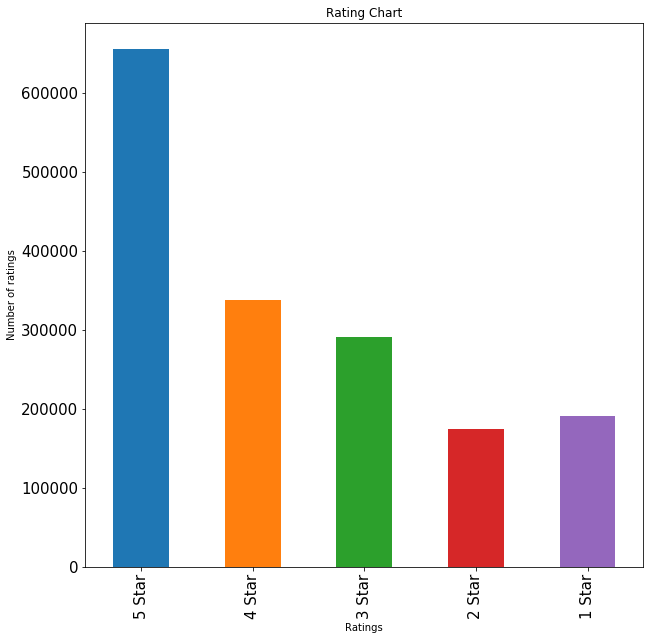

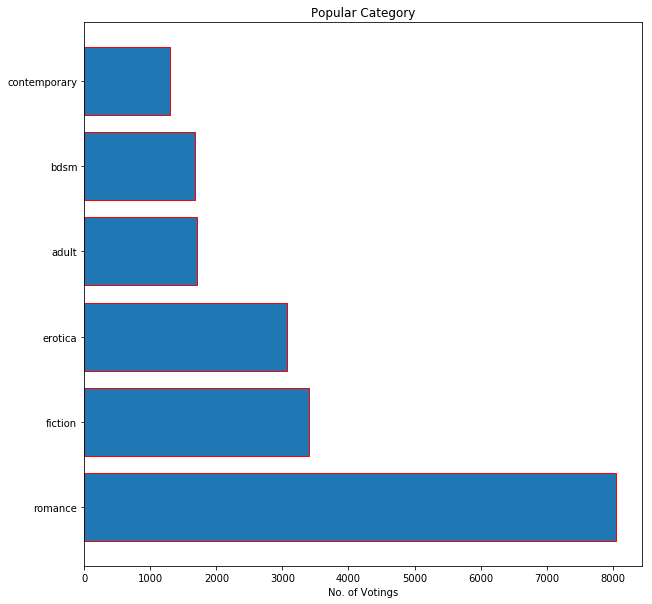

In [9]:
id = input("Enter the GoodRead Id shown above for additional details of the book: ")
Show_book_info(id)

Plot the **Average Rating** for books by the author against the **Year** of pulication

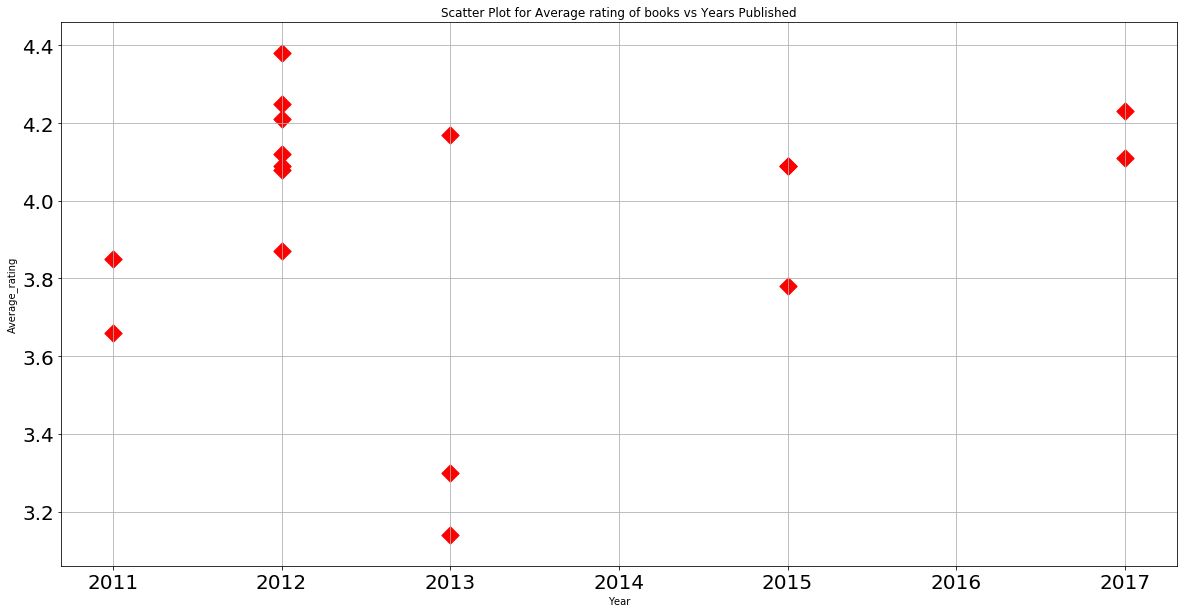

In [10]:
#book_df["Year"] = book_df["Year"].fillna(book_df["Year"].mean())
book_df.plot(kind='scatter', x="Year", y="Average_rating", marker = 'D', title='Scatter Plot for Average rating of books vs Years Published', figsize=(20,10),grid=True, fontsize=20, legend = True,s=150, c='r')

## Calculate the category list for the searched Author

_Takes a while to run_ 

In [11]:
category_list = list()
for book in auth_book['GoodRead_id']:
    count = 0
    rating_data = get_rating_info(book)
    for genre in rating_data['Genre']:
        category_list.append(genre)
        count += 1
        if count > 3:
            break   

## Category Visualizations for searched authors

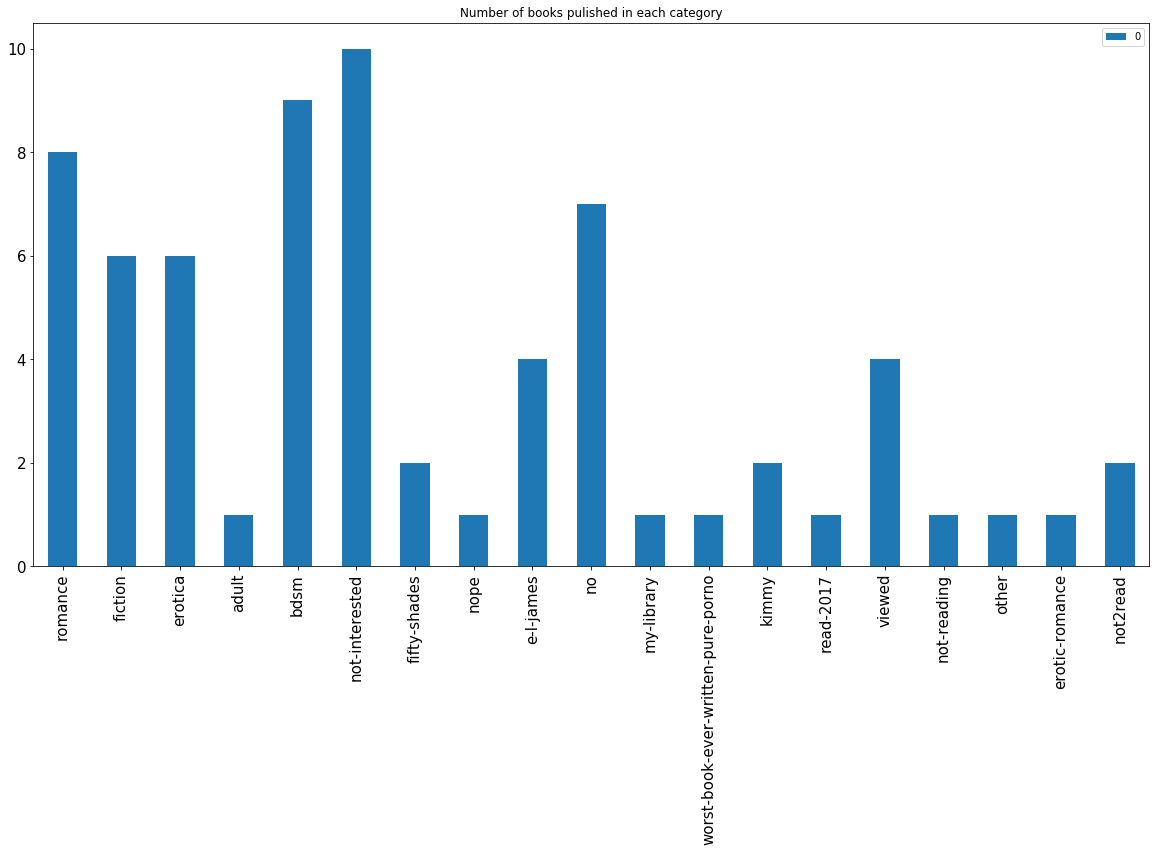

In [12]:
cat_count = Counter(category_list)
df = pd.DataFrame.from_dict(cat_count, orient='index')
df.plot(kind='bar', title='Number of books pulished in each category', figsize=(20,10), fontsize=15)

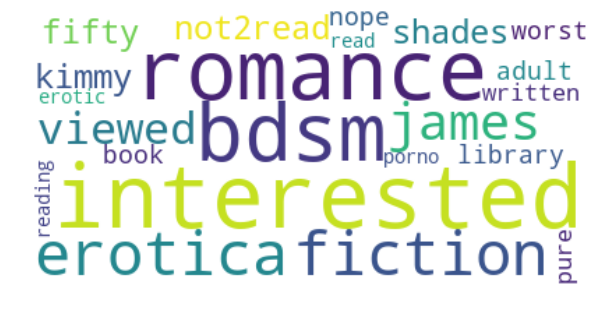

In [13]:
category_str = ""
for i in category_list:
    category_str += i+" "
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(category_str)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()